# Estimating Fluxes at Steady State

Metabolic fluxes at steady state are obtained by nonlinear optimization which seeks to minimize the difference between the measured labeling patterns and the simulated ones when the system reaches a stable status both metabolically and isotopically. The problem can be formulated as below:

\begin{aligned}
\min \quad & {\rm{ }}{({{\bf{x}}_{sim}}({\bf{u}}) - {{\bf{x}}_{exp}})^T}{\bf{\Sigma }}_{{{\bf{x}}_{exp}}}^{ - 1}({{\bf{x}}_{sim}}({\bf{u}}) - {{\bf{x}}_{exp}}) + {({{\bf{v}}_{sim}}({\bf{u}}) - {{\bf{v}}_{exp}})^T}{\bf{\Sigma }}_{{{\bf{v}}_{exp}}}^{ - 1}({{\bf{v}}_{sim}}({\bf{u}}) - {{\bf{v}}_{exp}})\\
s.t. \quad & {\rm{   }}{\bf{v}} = {\bf{Nu}} \ge {\bf{0}}\\
&{\rm{       }}{\bf{v}}_{net}^{lb} \le {{\bf{v}}_{net}} = {\bf{Tv}} = {\bf{TNu}} \le {\bf{v}}_{net}^{ub}
\end{aligned}

where ${\bf{x}}_{sim}$ and ${\bf{v}}_{sim}$ are simulated MDVs and fluxes, and they are both the functions of free flux $\bf{u}$. ${\bf{x}}_{exp}$ and ${\bf{v}}_{exp}$ are the measurements, whereas ${\bf{\Sigma }}_{{{\bf{x}}_{exp}}}^{ - 1}$ and ${\bf{\Sigma }}_{{{\bf{v}}_{exp}}}^{ - 1}$ are the inverses of the covariance matrix of measurements. $\bf{N}$ is the null space of stoichiometric matrix of the network reactions, and $\bf{T}$ denotes the matrix transforming total fluxes to net fluxes.

## Solving the fluxes

We will use the toy model for demonstration. As we do before, a model is built by reading from the [file](https://github.com/Chaowu88/freeflux/tree/main/models/toy).

In [1]:
from freeflux import Model

MODEL_FILE = 'toy_reactions.tsv' #'path/to/reactions.tsv'

model = Model('demo')
model.read_from_file(MODEL_FILE)

fit = model.fitter('ss')

Then we specify the labeling strategy by:

In [2]:
fit.set_labeling_strategy('AcCoA', labeling_pattern = ['01', '11'], 
                                   percentage = [0.25, 0.25], 
                                   purity = [1, 1])   # call this method for each labeled substrate

Measurement is set by `set_measured_MDV` for MDV and `set_measured_flux` for flux (if any). To input a set of measurements, it is convenient to load from [files](https://github.com/Chaowu88/freeflux/tree/main/models/toy) by `set_measured_MDVs_from_file` and `set_measured_fluxes_from_file` methods. We assume here the measured fluxes are net ones since the total fluxes are basically not measurable.

In [2]:
MEASURED_MDV_FILE = 'toy_mea_MDVs.tsv'   #'path/to/measured_MDVs.tsv'
MEASURED_FLUX_FILE = 'toy_mea_fluxes.tsv'   #'path/to/measured_fluxes.tsv'

fit.set_measured_MDVs_from_file(MEASURED_MDV_FILE)
fit.set_measured_fluxes_from_file(MEASURED_FLUX_FILE)

Now we set the lower and upper bounds of net fluxes:

In [4]:
fit.set_flux_bounds('all', bounds = [-100, 100]) # "all" stand for all fluxes; use reaction ID for specific flux

<div class="alert alert-info">

<b>Note:</b> <br></br> The upper bound should be great than the lower bound. Use `set_measured_flux` or `set_measured_fluxes_from_file` for equality assignment.

</div>

The fluxes can be solved by:

In [5]:
fit.prepare(n_jobs = 3)
res = fit.solve(solver = 'slsqp', ini_fluxes = None, fit_measured_fluxes = True)
print(res.optimization_successful)


fitting [elapsed: 0:00:01]

True


Currently, two methods are available to solve the fitting problem, i.e., the sequential least squares programming (solver = "slsqp") and the r-algorithm with adaptive space dilation (solver = "ralg", OpenOpt required, please see the [Installation](https://freeflux.readthedocs.io/en/latest/installation.html) for more details). 

Argument `ini_fluxes` is used to enter an initial guess of the fluxes which could be derived from the last successful optimization. The argument takes a Pandas [Series](https://pandas.pydata.org/docs/reference/api/pandas.Series.html) object or a .tsv/.xlsx file. A good initial guess is helpful for convergence. If None, the solve will use a random initial guess sampled from the feasible region of fluxes estimated by flux variability analysis [(FVA)](https://freeflux.readthedocs.io/en/latest/fba.html).

Argument `fit_measured_fluxes` determines whether the second flux item is included in the objective function of the above formulated problem. Set this argument `True` if exchange fluxes, e.g., substrate uptake rate, product secretion rate or the specific cell growth is measured and provided by `set_measured_flux` or `set_measured_fluxes_from_file`. In this case, the estimated fluxes will have the same unit with the measured ones which is usually mmol gCDW$^{-1}$ h$^{-1}$ or $\mu$mol gCDW$^{-1}$ s$^{-1}$. If no measured flux is provided, one can still provide a substrate uptake rate and fix the value at 100. In this case, the estimated fluxes will have the relative values which is normalized to the substrate uptake rate.

Other arguments like `tol` and `max_iters` controls when the optimiaztion stops, and `show_progress` controls whether to show the time elapsed.

The optimization results are stored in the FitResults object, and the optimal objective can be accessed by the attribute `opt_objective`:

In [6]:
print(res.opt_objective)

0.002

The optimal net and total fluxes can be accessed by attributes `opt_net_fluxes` and `opt_total_fluxes`:

In [7]:
print(res.opt_net_fluxes)

v1: 10.0
v2: 10.0
v3: 4.993
v4: 5.007
v5: 5.007
v6: 5.007
v7: 4.993

In [8]:
print(res.opt_total_fluxes)

v1: 10.0
v2: 10.0
v3: 4.993
v4: 5.007
v5: 5.007
v6_f: 62.369
v6_b: 57.362
v7: 4.993

The goodness of fit can be checked by the normal probability plot of weighted residuals, which can be done by the following command:

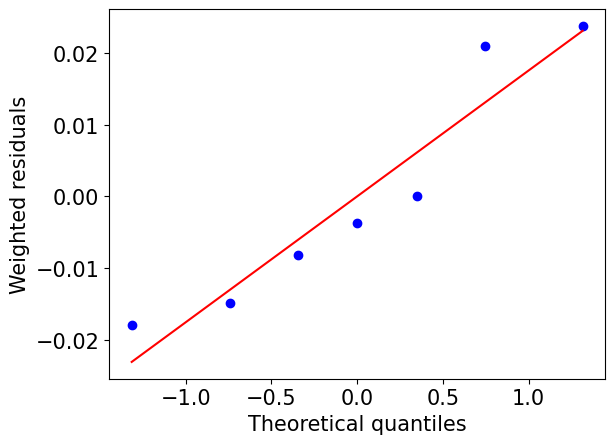

In [9]:
res.plot_normal_probability(show_fig = True, output_dir = None)

The weighted residuals are expected to be normally distributed and thus located closely to the red line.

We can also compare the simulated and experimental measurements by:

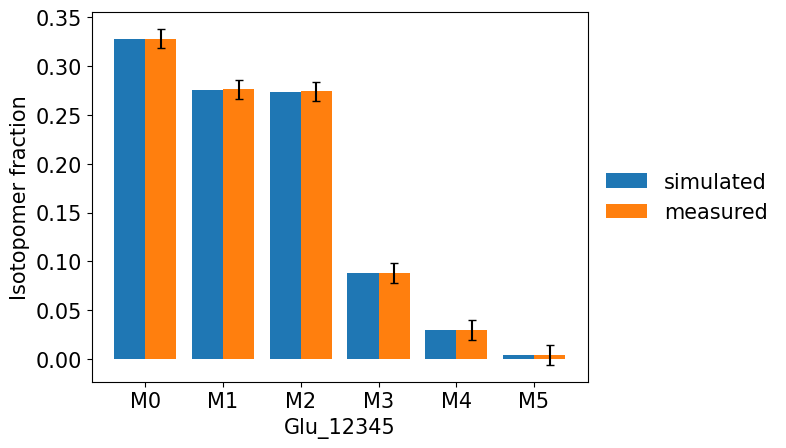

In [10]:
res.plot_simulated_vs_measured_MDVs(show_fig = True, output_dir = None)

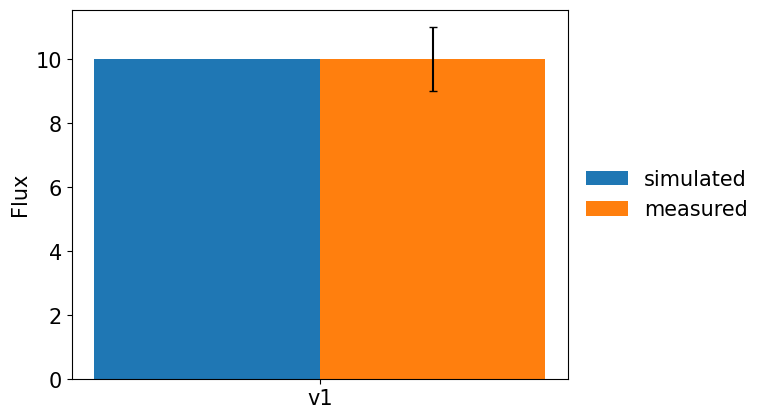

In [11]:
res.plot_simulated_vs_measured_fluxes(show_fig = True, output_dir = None)

Symmetric confidence intervals of fluxes can be obtained at convergence using a [local estimation method](https://pubmed.ncbi.nlm.nih.gov/16631402/) by the command:

In [12]:
print(res.estimate_confidence_intervals(which = 'net', confidence_level = 0.95)) # which = "total" for total fluxes

v1: [6.818, 13.182]
v2: [6.818, 13.182]
v3: [3.239, 6.747]
v4: [3.249, 6.765]
v5: [3.249, 6.765]
v6: [3.249, 6.765]
v7: [3.239, 6.747]


We can also evaluate the contribution of measurement variances to the uncertainty of estimated fluxes by calculating the contribution matrix:

In [13]:
print(res.estimate_contribution_matrix(which = 'net')) # which = "total" for total fluxes

    Glu_12345_m0  Glu_12345_m1  Glu_12345_m2  Glu_12345_m3  Glu_12345_m4  \
v1  3.752574e-30  8.588299e-30  1.343010e-29  4.756250e-30  6.748237e-31   
v2  3.517845e-30  8.592559e-30  1.346500e-29  4.793780e-30  8.443941e-31   
v3  1.253004e-01  2.059064e-04  2.293564e-03  4.182793e-02  8.895803e-03   
v4  1.247207e-01  2.049537e-04  2.282951e-03  4.163439e-02  8.854641e-03   
v5  1.247207e-01  2.049537e-04  2.282951e-03  4.163439e-02  8.854641e-03   
v6  1.247207e-01  2.049537e-04  2.282951e-03  4.163439e-02  8.854641e-03   
v7  1.253004e-01  2.059064e-04  2.293564e-03  4.182793e-02  8.895803e-03   

    Glu_12345_m5        v1  
v1  3.168464e-32  1.000000  
v2  3.322300e-32  1.000000  
v3  4.665570e-04  0.821010  
v4  4.643982e-04  0.821838  
v5  4.643982e-04  0.821838  
v6  4.643982e-04  0.821838  
v7  4.665570e-04  0.821010  


as well as the sensitivities of estimated fluxes with respect to measurement perturbations by:

In [14]:
print(res.estimate_sensitivity(which = 'net')) # which = "total" for total fluxes

    Glu_12345_m0  Glu_12345_m1  Glu_12345_m2  Glu_12345_m3  Glu_12345_m4  \
v1 -1.937156e-13 -2.930580e-13 -3.664711e-13 -2.180883e-13 -8.214765e-14   
v2 -1.875592e-13 -2.931307e-13 -3.669468e-13 -2.189470e-13 -9.189092e-14   
v3  1.950557e+01  7.907102e-01 -2.638990e+00 -1.126978e+01 -5.197266e+00   
v4 -1.950557e+01 -7.907102e-01  2.638990e+00  1.126978e+01  5.197266e+00   
v5 -1.950557e+01 -7.907102e-01  2.638990e+00  1.126978e+01  5.197266e+00   
v6 -1.950557e+01 -7.907102e-01  2.638990e+00  1.126978e+01  5.197266e+00   
v7  1.950557e+01  7.907102e-01 -2.638990e+00 -1.126978e+01 -5.197266e+00   

    Glu_12345_m5        v1  
v1 -1.780018e-14  1.000000  
v2 -1.822718e-14  1.000000  
v3 -1.190241e+00  0.499294  
v4  1.190241e+00  0.500706  
v5  1.190241e+00  0.500706  
v6  1.190241e+00  0.500706  
v7 -1.190241e+00  0.499294  


`with` statement can be used for flux estimation:

In [15]:
with model.fitter('ss') as fit:
    fit.set_labeling_strategy('AcCoA', labeling_pattern = ['01', '11'], 
                                       percentage = [0.25, 0.25], 
                                       purity = [1, 1])
    fit.set_measured_MDVs_from_file(MEASURED_MDV_FILE)
    fit.set_measured_fluxes_from_file(MEASURED_FLUX_FILE)
    fit.prepare(n_jobs = 3)
    res = fit.solve(solver = 'slsqp', ini_fluxes = None, fit_measured_fluxes = True)
print(res.optimization_successful)


fitting [elapsed: 0:00:01]

True


A more complex example of steady state fitting using an *E. coli* model is provided in the script "[tutorial_ecoli_steady_state_estimation.py](https://github.com/Chaowu88/freeflux/tree/main/tutorials)"

## Dilution parameter

Sometimes, amino acids measured could have significantly lower fractional labeling (13C enrichment) than other metabolites, which is probably caused by the unlabeled fraction introduce from inoculum, inactive pool or media. In this case, dilution parameters are needed for a better fitting of data. This can be achieved by adding several special reactions to the network.

For example, we add the following three reactions to account for the dilution effect of metabolite A with three C atoms:

v1: 0A(abc) $\rightarrow$ As(abc)\
v2: 0Au(abc) $\rightarrow$ As(abc)\
v3: As(abc) $\rightarrow$ sink

where A is the metabolite involved in metabolic reactions, Au is the metabolically inactive (unlabeled) fraction and As is the psedo-metabolite denoting that measured in samples. The zero coefficient in v1 and v2 guarantees the additional metabolites will have no effect on the mass balance of network reactions. The flux values of the reactions could be arbitrary, but the ratio v2/(v1+v2) is determined by the labeling patterns of A, Au and As, which is estimated as the dilution parameter. The additional reactions are useful to account for the dilution effect of measured metabolites, e.g., amino acids. As for the unmeasured metabolites, e.g., CO$_2$, only one reaction is needed:

v1: 0Au(abc) $\rightarrow$ 0A(abc)

The the zero coefficient on both sides excludes the reaction from mass balance, leaving it only to EMU decompostion.

Then we need to tell the decomposer the unlabeled dilution source(s), i.e., "Au" in the above example by setting the argument "dilution_from = 'Au'" in the `prepare` method.

## Solving the fluxes with confidence intervals

In some cases, the uncertainty of estimated flxues needs to be evaluated by calculating the confidence intervals (CIs). FreeFlux uses Monte Carlo method to estiamte CIs. The commands are similar to those for flux estimation except that method `solve_with_confidence_intervals` is used instead.

In [16]:
with model.fitter('ss') as fit:
    fit.set_labeling_strategy('AcCoA', ['01', '11'], [0.25, 0.25], [1, 1])
    fit.set_flux_bounds('all', bounds = [-100, 100]) 
    fit.set_measured_MDVs_from_file(MEASURED_MDV_FILE)
    fit.set_measured_fluxes_from_file(MEASURED_FLUX_FILE)
    fit.prepare(n_jobs = 3)
    res = fit.solve_with_confidence_intervals(n_runs = 90, n_jobs = 3)
print(res.estimate_confidence_intervals(which = 'net', confidence_level = 0.95))


fitting with CIs [elapsed: 0:00:21]

v1: [8.487, 11.602]
v2: [8.487, 11.602]
v3: [4.195, 6.155]
v4: [4.002, 5.806]
v5: [4.002, 5.806]
v6: [4.002, 5.806]
v7: [4.195, 6.155]


<div class="alert alert-info">

<b>Note:</b> <br></br> It is highly recommended to run with parallel jobs for estimating flux CIs of large-sized models.

</div>

A more complex example of estimating flux CIs of an *E. coli* model is provided in the script "[tutorial_ecoli_steady_state_estimation.py](https://github.com/Chaowu88/freeflux/tree/main/tutorials)"